In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
from skimage.io import imsave
from scipy.spatial import KDTree
from cell_segmentation_adaptive import segment_cell_adaptive
from draw_spots import crop_df

# BASE_DIR = Path('/mnt/data/local_processed_data')
# RUN_ID = '20221219_PRISM_E13.5_2_7_Three'
# src_dir = BASE_DIR / f'{RUN_ID}_processed'
src_dir = Path('./E12.5/1-2')
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
visual_dir = src_dir / 'visualization'
visual_dir.mkdir(exist_ok=True)

In [2]:
#read cell centroid
centroids = pd.read_csv(seg_dir/'centroids_all.csv', header=None).to_numpy()
len(centroids)

486682

In [3]:
#assign rna to nearest centroid
rna_df = pd.read_csv(read_dir/'mapped_genes_reduced.csv')
rna_pos = rna_df[['Y', 'X']].to_numpy()
tree = KDTree(centroids)
distances, indices = tree.query(rna_pos, k=1, distance_upper_bound=100)
rna_df['Cell Index'] = indices
rna_df = rna_df[rna_df['Cell Index'] < centroids.shape[0]]
rna_df.to_csv(visual_dir/'rna_labeled.csv',index=False)
rna_df

,Y,X,Gene,Cell Index
0,4809,43277,PRISM_10,20486
1,5162,15777,PRISM_10,24329
2,3341,21903,PRISM_10,6406
3,25992,28145,PRISM_10,317765
4,7695,11848,PRISM_10,46619
...,...,...,...,...
2647037,26180,51147,PRISM_3,321791
2647038,26596,24544,PRISM_3,329063
2647039,6841,33044,PRISM_3,38215
2647040,14712,53770,PRISM_3,137382


In [4]:
match_df = rna_df.copy()
match_df['Count'] = np.ones(len(match_df))
match_df_group = match_df[['Cell Index','Gene','Count']].groupby(['Cell Index','Gene']).count()
matrix = match_df_group.unstack().fillna(0)
matrix.columns = matrix.columns.droplevel()
matrix.columns.name = None
matrix.index.name = None
matrix = matrix.drop(columns='Other')
#Mask restoration
matrix['PRISM_2'] = matrix['PRISM_2']*5
matrix['PRISM_7'] = matrix['PRISM_7']*4
matrix['PRISM_22'] = matrix['PRISM_22']*5
matrix['PRISM_28'] = matrix['PRISM_28']*2
#matrix['PRISM_14'] = matrix['PRISM_14']/2 ### Afp high background in liver
#matrix['PRISM_28'] = matrix['PRISM_28']/5 ### Afp high background in liver
# filter according to max value
matrix['max'] = matrix.max(axis =1)
matrix = matrix[matrix['max']>=2]
# filter according to sum value
#matrix['sum'] = matrix.iloc[:,0:30].sum(axis=1)
#matrix = matrix[matrix['sum']>=10]
#matrix.to_csv(visual_dir/'expression_matrix.csv')
matrix


,PRISM_1,PRISM_10,PRISM_11,PRISM_12,PRISM_13,PRISM_14,PRISM_15,PRISM_16,PRISM_17,PRISM_18,...,PRISM_29,PRISM_3,PRISM_30,PRISM_4,PRISM_5,PRISM_6,PRISM_7,PRISM_8,PRISM_9,max
9,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
486677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
486678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
486679,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [5]:
filtered_matrix = matrix
filtered_matrix = filtered_matrix.drop(columns='max') # drop sum
filtered_matrix = filtered_matrix.drop(columns='PRISM_2')
filtered_matrix = filtered_matrix.drop(columns='PRISM_1')
filtered_matrix = filtered_matrix.drop(columns='PRISM_22')
filtered_matrix = filtered_matrix.drop(columns='PRISM_6')
filtered_matrix = filtered_matrix.drop(columns='PRISM_9')
filtered_matrix = filtered_matrix.drop(columns='PRISM_13')
filtered_matrix['max_value'] = filtered_matrix.max(axis =1)
filtered_matrix['sum_value'] = matrix.iloc[:,0:25].sum(axis=1)
filtered_matrix['max_proportion'] = filtered_matrix['max_value'] / filtered_matrix['sum_value']
filtered_matrix['max'] = filtered_matrix.iloc[:,0:25].idxmax(axis=1)
filtered_matrix['Cell_Index'] = filtered_matrix.index
type_dict = {
    'PRISM_1': 13,
    'PRISM_2': 13,
    'PRISM_3': 5,
    'PRISM_4': 8,
    'PRISM_5': 5,
    'PRISM_6': 13,
    'PRISM_7': 4,
    'PRISM_8': 5,
    'PRISM_9': 13,
    'PRISM_10': 0,
    'PRISM_11': 10,
    'PRISM_12': 5,
    'PRISM_13': 13,
    'PRISM_14': 6,
    'PRISM_15': 5,
    'PRISM_16': 5,
    'PRISM_17': 7,
    'PRISM_18': 3,
    'PRISM_19': 3,
    'PRISM_20': 1,
    'PRISM_21': 2,
    'PRISM_22': 13,
    'PRISM_23': 11,
    'PRISM_24': 0,
    'PRISM_25': 5,
    'PRISM_26': 4,
    'PRISM_27': 5,
    'PRISM_28': 3,
    'PRISM_29': 2,
    'PRISM_30': 9, 
}
filtered_matrix['Cluster'] = filtered_matrix['max'].map(type_dict)

In [6]:
# Secondary threshold STRATEGY_max proportion: max distribution of a gene

# 0
filtered_matrix.loc[(filtered_matrix['max_proportion'] <= 0.2),'Cluster'] = 13
filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_7')&(filtered_matrix['max_proportion'] <= 0.8),'Cluster'] = 13 # 5 for 
#filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_24')&(filtered_matrix['max_proportion'] <= 0.8),'Cluster'] = 13 # 5 for 
#filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_6')&(filtered_matrix['max_proportion'] <= 0.5),'Cluster'] = 13 # 5 for
#filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_17')&(filtered_matrix['max_proportion'] <= 0.5),'Cluster'] = 13 # 5 for 
#filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_28')&(filtered_matrix['max_proportion'] <= 0.3),'Cluster'] = 13 # 5 for  
#filtered_matrix.loc[(filtered_matrix['max'] == 'PRISM_7')&(filtered_matrix['max_proportion'] <= 0.8),'Cluster'] = 13 # 5 for 

# 6 rescue
#filtered_matrix.loc[(filtered_matrix['Cluster'] == 10)&(filtered_matrix['PRISM_14']/filtered_matrix['sum_value'] >= 0.3),'Cluster'] = 6
#filtered_matrix.loc[(filtered_matrix['Cluster'] == 8)&(filtered_matrix['PRISM_14']/filtered_matrix['sum_value'] >= 0.3),'Cluster'] = 6


In [7]:
# check 'other' cell number
len(filtered_matrix[filtered_matrix['Cluster']==13])

91177

In [8]:
factor = filtered_matrix[['Cell_Index','Cluster']]
type_indices = {}
for type in range(len(np.unique(factor['Cluster']))):
    type_indices[type] = list(factor[factor['Cluster']==type]['Cell_Index'])

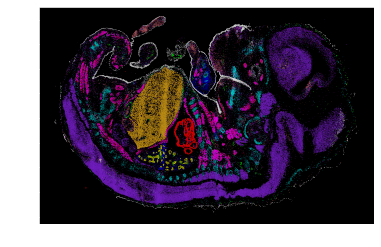

In [10]:
from scipy.spatial import ConvexHull
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('dark_background')
#plt.style.use('default')
from matplotlib.colors import ListedColormap
from scipy.interpolate import splprep
from scipy.interpolate import splev
from scipy.spatial.qhull import QhullError
matplotlib.rcParams.update({
"pgf.texsystem": "xelatex",
'font.family': 'serif',
'text.usetex': True,
'pgf.rcfonts': False,
'figure.dpi': 300,
})
x = 0.1
y = 1
df = pd.read_csv(visual_dir/'rna_labeled.csv')
hulls = {}
df_group = df.groupby('Cell Index')
for group in df_group:
    coordinates = group[1][['Y', 'X']].values   
    try:
        hull = ConvexHull(coordinates)
        coordinate_path = np.vstack((coordinates[hull.vertices,0], coordinates[hull.vertices,1])).T
        hulls[group[0]] = coordinate_path
    except QhullError:
        pass
#fig = plt.figure(figsize=(6,4))
fig,ax = plt.subplots() #figsize=(6.2,4.7)
#for idx in hulls:
  #  ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "lightgray", linewidth=0.5)
for idx in type_indices[0]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "white", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[1]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "lime", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[2]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "magenta", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[3]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "red", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[4]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "cyan", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[5]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "blueviolet", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[6]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "goldenrod", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[7]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "darkorange", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[8]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "orangered", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[9]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "lightcoral", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[10]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "yellow", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[11]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "blue", linewidth=x, alpha=y)
    except KeyError:
        pass
#for idx in type_indices[3]:
 #   try:
  #      ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "gray", linewidth=0.5)
   # except KeyError:
    #    pass
#for idx in list(type_indices[5]):
 #   ax.fill(hulls[idx][:,0], hulls[idx][:,1], color = "blue", linewidth=0.5)
#for idx in type_indices[3]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "blue", linewidth=0.5)
#for idx in type_indices[4]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "yellow", linewidth=0.5)
#for idx in type_indices[5]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "red", linewidth=0.5)
#for idx in type_indices[6]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "lime", linewidth=0.5)
plt.savefig(visual_dir/'whole_embryo_E13.5_2_12.pdf')
plt.show()
#plt.close()

(array([1.765e+03, 0.000e+00, 0.000e+00, 0.000e+00, 2.404e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 9.460e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 3.970e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.760e+02, 0.000e+00, 0.000e+00, 0.000e+00, 9.600e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.900e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.  ,  1.22,  1.44,  1.66,  1.88,  2.1 ,  2.32,  2.54,  2.76,
         2.98,  3.2 ,  3.42,  3.64,  3.86,  4.08,  4.3 ,  4.52,  4.74,
         4.96,  5.18,  5.4 ,  5.62,  5.84,  6.06,  6.28,  6.5 ,  6.72,
         6.94,  7.16,  7.38,  7.6 ,  7.82,  8.04,  8.26,  8.48,  8.7 ,
         8.92,  9.14,  9.36,  9.58,  9.8 , 10.02, 10.24, 10.46, 10.68,
        10.9 , 11.12,

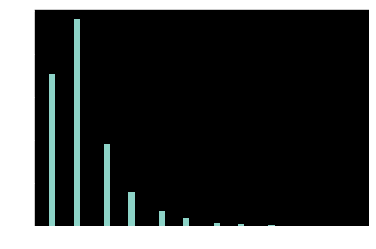

In [11]:
# Single gene expression level
import matplotlib.pyplot as plt
plt.hist(filtered_matrix[filtered_matrix['max']=='PRISM_23']['max_value'], bins=50)

In [47]:
# DRAW BINNING CELL TYPE
from skimage.io import imread
from skimage.io import imsave
from glob import glob
import numpy as np
import os
from tqdm import tqdm

#filtered_matrix = filtered_matrix.drop(filtered_matrix[filtered_matrix['Cluster']==18].index)
filtered_matrix['Y'] = centroids[filtered_matrix['Cell_Index'],0]
filtered_matrix['X'] = centroids[filtered_matrix['Cell_Index'],1]
result_df = filtered_matrix[['Y','X','Cell_Index','Cluster']].reset_index().drop(columns=['index'])
clusters = set(result_df['Cluster'])
im = imread(stc_dir/'cyc_1_cy5.tif')
im = np.zeros((im.shape[1],im.shape[0]),dtype=np.uint16)

def plot_density_downsample(df,filename,fac=100):
    y = (im.shape[1] // fac) + 1
    x = (im.shape[0] // fac) + 1
    coordinates = df[['Y','X']].to_numpy()
    canvas = np.zeros((y*fac,x*fac),dtype=np.uint16)
    canvas[coordinates[:,0],coordinates[:,1]] = 1
    canvas_down = canvas.reshape(y,fac,x,fac).sum(-1).sum(1)
    imsave(filename,canvas_down.astype(np.uint16),check_contrast=False)

try:
    os.mkdir(visual_dir/'cell_type_bin')
except FileExistsError:
    pass

for cluster in tqdm(clusters):
    if glob(os.path.join(visual_dir/'cell_type_bin',f'{cluster}.tif')):
        continue
    else:
        df = result_df[result_df['Cluster']==cluster]
        plot_density_downsample(df,visual_dir/f'cell_type_bin/{cluster}.tif')

100%|██████████| 13/13 [00:35<00:00,  2.72s/it]


In [81]:
# Single gene expression level

a = 'PRISM_17'
filtered_matrix_select =  filtered_matrix[filtered_matrix['max']==f'{a}'].copy()
#filtered_matrix_select =  filtered_matrix.copy() # peofile this gene expression in all cells
level = int(max(filtered_matrix[filtered_matrix['max']==f'{a}']['max_value']))
filtered_matrix_select['Level'] = filtered_matrix_select[f'{a}']
filtered_matrix_select = filtered_matrix_select.astype({'Level':int})
factor = filtered_matrix_select[['Cell_Index','Level']]
type_indices = {}
for type in np.unique(factor['Level']):
    type_indices[type] = list(factor[factor['Level']==type]['Cell_Index'])

from scipy.spatial import ConvexHull
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.style.use('dark_background')
plt.style.use('default')
from matplotlib.colors import ListedColormap
from scipy.interpolate import splprep
from scipy.interpolate import splev
from scipy.spatial.qhull import QhullError
matplotlib.rcParams.update({
"pgf.texsystem": "xelatex",
'font.family': 'serif',
'text.usetex': True,
'pgf.rcfonts': False,
'figure.dpi': 1800,
})
x = 0.1
df = pd.read_csv(visual_dir/'rna_labeled.csv')
hulls = {}
df_group = df.groupby('Cell Index')
for group in df_group:
    coordinates = group[1][['Y', 'X']].values   
    try:
        hull = ConvexHull(coordinates)
        coordinate_path = np.vstack((coordinates[hull.vertices,0], coordinates[hull.vertices,1])).T
        hulls[group[0]] = coordinate_path
    except QhullError:
        pass
#fig = plt.figure(figsize=(65000,40000))
fig,ax = plt.subplots(figsize=(6.3,4)) #figsize=(6.2,4.7)
#for idx in hulls:
  #  ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "lightgray", linewidth=0.5)
for i in np.unique(filtered_matrix_select[f'{a}']):
    for idx in type_indices[i]:
        try:
            ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "darkorange", linewidth=x, alpha=i*2/level)
        except KeyError:
            pass
#for idx in type_indices[3]:
 #   try:
  #      ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "gray", linewidth=0.5)
   # except KeyError:
    #    pass
#for idx in list(type_indices[5]):
 #   ax.fill(hulls[idx][:,0], hulls[idx][:,1], color = "blue", linewidth=0.5)
#for idx in type_indices[3]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "blue", linewidth=0.5)
#for idx in type_indices[4]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "yellow", linewidth=0.5)
#for idx in type_indices[5]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "red", linewidth=0.5)
#for idx in type_indices[6]:
 #   plt.fill(hulls[idx][:,0], hulls[idx][:,1], color = "lime", linewidth=0.5)
plt.savefig(visual_dir/f'whole_embryo_E13.5_prism_{a}_Profile.tif', transparent = True)
#plt.show()
plt.close()
